# Deep Learning: Endoscopy segmentation.
[Dataset](https://www.kaggle.com/datasets/newslab/cholecseg8k?resource=download)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import cv2
import tensorflow as tf
from skimage import exposure
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from glob import glob
import pickle

In [2]:
print('GPU avalible: ' + str(len(tf.config.get_visible_devices('GPU')) > 0))
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  print('Cannot use memory growth')


GPU avalible: True


## Data preparation.

In [3]:
imgs = glob(f'../*/*/*/frame_*_endo.png')[2000:]
masks = glob(f'../*/*/*/frame_*_endo_watershed_mask.png')[2000:]

assert len(imgs) == len(masks)

print(f'Number of samples: {str(len(masks))}')

Number of samples: 6080


In [4]:
HEIGHT, WIDTH = 128, 256
N = len(masks)

In [5]:
X, y = [], []

for img, mask in zip(imgs, masks):
    img = cv2.imread(img)
    img = img[10:-10, 10:-10,:]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (WIDTH, HEIGHT))
    img = img / 255
    X.append(img)

    mask = cv2.imread(mask)
    mask = mask[10:-10, 10:-10,:]
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.resize(mask, (WIDTH, HEIGHT), interpolation=cv2.INTER_NEAREST)
    mask = np.expand_dims(mask, axis=-1)

    y.append(mask)

X = np.array(X)
y = np.array(y)

assert X.shape[0:-1] == y.shape[0:-1]

X.shape, y.shape

((6080, 128, 256, 3), (6080, 128, 256, 1))

In [6]:
def dump_data(X_data, y_data):
    X_file = open('../resources/X_dump.p', 'ab')
    y_file = open('../resources/y_dump.p', 'ab')

    pickle.dump(X_data, X_file)
    pickle.dump(y_data, y_file)

    X_file.close()
    y_file.close()

# dump_data(X, y)

In [7]:
def load_data():
    X_file = open('../resources/X_dump.p', 'rb')
    y_file = open('../resources/y_dump.p', 'rb')

    X_data = pickle.load(X_file)
    y_data = pickle.load(y_file)

    X_file.close()
    y_file.close()
    return X_data, y_data

# X, y = load_data()

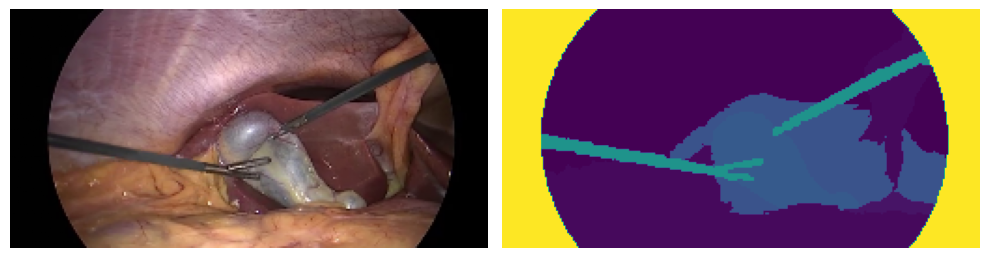

In [8]:
idx = random.randint(0, len(X)-1)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(X[idx])
plt.axis("off")
plt.subplot(122)
plt.imshow(y[idx])
plt.axis("off")
plt.tight_layout()
plt.show()

In [9]:
labels = [
    [11],
    [21],
    [13],
    [12],
    [31],
    [23],
    [24],
    [25],
    [32],
    [22],
    [33],
    [5]
]

y_encoded = np.zeros((N, HEIGHT, WIDTH, 1), dtype=np.uint8)

for i, label in enumerate(labels):
    y_encoded[np.all(label == y, axis=-1)] = i + 1
 
y = tf.keras.utils.to_categorical(y_encoded, num_classes=13)

In [10]:
# dump_data(X, y)
# X, y = load_data()
np.unique(y_encoded[0])

array([ 0,  1,  2,  3,  4,  5,  6, 10, 11], dtype=uint8)

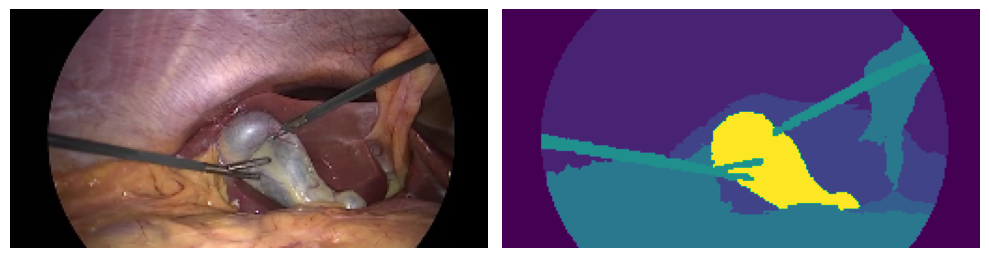

In [11]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(X[idx])
plt.axis("off")
plt.subplot(122)
plt.imshow(tf.argmax(y[idx], axis=-1))
plt.axis("off")
plt.tight_layout()
plt.show()

## U-Net

In [12]:
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = tf.keras.layers.MaxPool2D(2)(f)
   p = tf.keras.layers.Dropout(0.3)(p)

   return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = tf.keras.layers.concatenate([x, conv_features])
   # dropout
   x = tf.keras.layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x

def build_unet_model(n_filters=64, n_classes=2):
   # inputs
   inputs = tf.keras.layers.Input(shape=(HEIGHT,WIDTH,3))

   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, n_filters)
   # 2 - downsample
   f2, p2 = downsample_block(p1, n_filters*2)
   # 3 - downsample
   f3, p3 = downsample_block(p2, n_filters*4)
   # 4 - downsample
   f4, p4 = downsample_block(p3, n_filters*8)

   # 5 - bottleneck
   bottleneck = double_conv_block(p4, n_filters*16)

   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, n_filters*8)
   # 7 - upsample
   u7 = upsample_block(u6, f3, n_filters*4)
   # 8 - upsample
   u8 = upsample_block(u7, f2, n_filters*2)
   # 9 - upsample
   u9 = upsample_block(u8, f1, n_filters)

   # outputs
   
   activation = 'sigmoid' if n_classes == 2 else 'softmax'
   outputs = tf.keras.layers.Conv2D(n_classes, 1, padding="same", activation=activation)(u9)

   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model

In [13]:
def dice_coeficient(y_true, y_pred):
    T = tf.keras.backend.flatten(y_true)
    P = tf.keras.backend.flatten(y_pred)

    intersection = tf.keras.backend.sum(T * P)
    dice = (2 * intersection) / (tf.keras.backend.sum(T + P))
    return dice

def dice_loss(y_true, y_pred):
    return 1 - dice_coeficient(y_true, y_pred)

def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    T = tf.keras.backend.flatten(y_true)
    P = tf.keras.backend.flatten(y_pred)
    TP = tf.keras.backend.sum(T * P)
    FN = tf.keras.backend.sum(T * (1 - P))
    FP = tf.keras.backend.sum((1 - T) * P)
    return (TP + smooth) / (TP + alpha * FN + (1 - alpha) * FP + smooth)


def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)


def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return tf.keras.backend.pow((1 - tv), gamma)

In [14]:
unet_model = build_unet_model(n_filters=32, n_classes=13)
unet_model.load_weights('../models/u-net_39-0.22_tversky_loss.hdf5')
unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss=focal_tversky_loss,
    metrics=[tf.metrics.MeanIoU(num_classes=13), dice_coeficient]
)

unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 128, 32)  0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43) 

print('\n\t EVALUATION\n')
unet_model.evaluate(
    X_test, 
    y_test,
    batch_size=32
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    '../models/u-net_trainCP_tversky_loss.hdf5',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
)

print('\n\t TRAINING\n')

model_history = unet_model.fit(
    X_train,
    y_train,
    epochs=60,
    batch_size=32,
    validation_data=(X_test, y_test),
    use_multiprocessing=True,
    callbacks=[checkpoint],
    verbose=1
)

unet_model.save_weights('../models/u-net_{val_loss:.5f}_tversky_loss.hdf5')


	 EVALUATION

38/38 [==============================] - 14s 111ms/step - loss: 0.2824 - mean_io_u: 0.8303 - dice_coeficient: 0.8142

	 TRAINING

Epoch 1/60
152/152 [==============================] - 73s 440ms/step - loss: 0.2262 - mean_io_u: 0.8709 - dice_coeficient: 0.8619 - val_loss: 0.2141 - val_mean_io_u: 0.8787 - val_dice_coeficient: 0.8715

Epoch 00001: val_loss improved from inf to 0.21411, saving model to ../models\u-net_trainCP_tversky_loss.hdf5
Epoch 2/60
152/152 [==============================] - 52s 339ms/step - loss: 0.2184 - mean_io_u: 0.8764 - dice_coeficient: 0.8682 - val_loss: 0.2128 - val_mean_io_u: 0.8801 - val_dice_coeficient: 0.8726

Epoch 00002: val_loss improved from 0.21411 to 0.21276, saving model to ../models\u-net_trainCP_tversky_loss.hdf5
Epoch 3/60
152/152 [==============================] - 57s 374ms/step - loss: 0.2168 - mean_io_u: 0.8772 - dice_coeficient: 0.8695 - val_loss: 0.2119 - val_mean_io_u: 0.8807 - val_dice_coeficient: 0.8733

Epoch 00003: val_lo

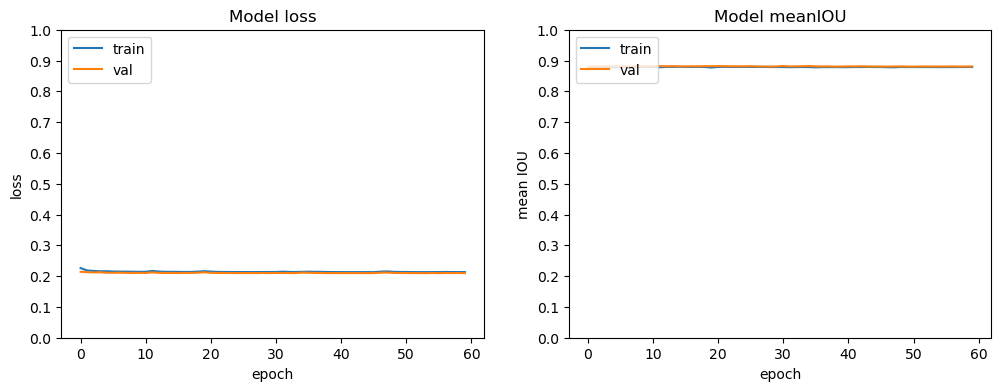

In [16]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(122)
plt.plot(model_history.history['mean_io_u'])
plt.plot(model_history.history['val_mean_io_u'])
plt.title('Model meanIOU')
plt.ylabel('mean IOU')
plt.xlabel('epoch')
plt.yticks(np.arange(0, 1.1, 0.1))

plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [17]:
# unet_model = build_unet_model(n_filters=32, n_classes=13)
# unet_model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0e-4), 
#     loss=dice_loss,
#     metrics=[tf.metrics.MeanIoU(num_classes=13), dice_coeficient]
# )

# unet_model.load_weights('../models/u-net_100epochs.hdf5')

In [18]:
pred = unet_model.predict(X_test)
pred = np.array(pred)
pred = tf.argmax(pred, axis=-1)

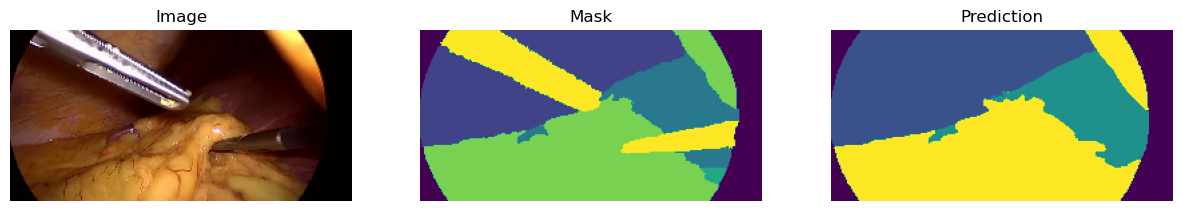

In [35]:
idx = random.randint(0, len(pred)-1)

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(X_test[idx])
plt.title('Image')
plt.axis("off")

plt.subplot(132)
plt.imshow(tf.argmax(y_test[idx], axis=-1))
plt.title('Mask')
plt.axis("off")

plt.subplot(133)
plt.imshow(pred[idx])
plt.title('Prediction')
plt.axis("off")

plt.show()

 --- 
 TFG - Alejandro García Mota